## Download data from link drive

In [ ]:
!gdown 1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_

Downloading...
From: https://drive.google.com/uc?id=1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_
To: /content/dataset.zip
100% 1.26G/1.26G [00:06<00:00, 205MB/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [ ]:
# copy to session dir
!mkdir datasets
# !cp /content/drive/MyDrive/datasets/dataset.zip /content/datasets/

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("dataset.zip", 'r')
zip_ref.extractall("/content/datasets/")
zip_ref.close()

----
### Importing Libraries

In [ ]:
# !pip install split-folders
# !pip install c-print
# from cprint import cprint

In [ ]:
import os
from glob import glob
import sys
# import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input, DenseNet201, DenseNet121


from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array

from tensorflow.keras.utils import to_categorical

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Prepare paths and Loading the Data

In [ ]:
# create directory
def mkdir(path):
  if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
# create shortcut of folders to specific place
# def link(src, dist):
#   if not os.path.exists(dist):
#     os.symlink(src, dist, target_is_directory=True)

In [ ]:
MAIN_PATH = "/content/datasets/chest_xray/"

# create validation directory
# mkdir(MAIN_PATH+'/val')

# get paths of folders of data
TRAIN_DATA_PATH = glob(MAIN_PATH+'train')[0]
TEST_DATA_PATH = glob(MAIN_PATH+'test')[0]
# VALID_DATA_PATH = glob(MAIN_PATH+'val')[0]

# get list of lables name
LABELS_OF_DATA = os.listdir(TRAIN_DATA_PATH)

# path of train data
TRAIN_N = glob(TRAIN_DATA_PATH)[0]+'/'+LABELS_OF_DATA[0]
TRAIN_P = glob(TRAIN_DATA_PATH)[0]+'/'+LABELS_OF_DATA[1]

In [ ]:
TRAIN_DATA_PATH, TEST_DATA_PATH, LABELS_OF_DATA

('/content/datasets/chest_xray/train',
 '/content/datasets/chest_xray/test',
 ['NORMAL', 'PNEUMONIA'])

### Split data into train and validation (if don't use pre-trained model)


In [ ]:
# splitfolders.ratio(TRAIN_DATA_PATH, output=VALID_DATA_PATH, seed=42, ratio=(.8, .2), move=False)

In [ ]:
# !rm -r /content/datasets/chest_xray/val

In [ ]:
# def img_train_vld_split(main_path, ratio=0.2, move=False):
#   mkdir(main_path+'/val/')
  
#   classes_dir = os.listdir(main_path+'/train/')
#   main_dir = main_path+'/train/'
#   size=0
#   count=0

#   for cls in classes_dir:
#     mkdir(main_path+'/val/'+cls)
#     if size==0:
#       size = int(ratio * len(os.listdir(main_dir+cls)))
#       # print(size)

#     for i, name in enumerate(os.listdir(main_dir+cls)):
#       print('move ', name, "--", cls, i+1)
#       if move:
#         splitfolders.shutil.move(main_dir+'/'+cls+'/'+name, main_path+'/val/'+cls)
#       else:
#         splitfolders.shutil.copy(main_dir+'/'+cls+'/'+name, main_path+'/val/'+cls)
#       count+=1
#       if count == size:
#         count=0
#         size=0
#         break

In [ ]:
# img_train_vld_split(MAIN_PATH, ratio=0.2, move=True)

In [ ]:
# !rm -r /content/datasets/chest_xray/val

### Creating Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
                                   rescale=1/255,
                                  #  samplewise_center=True,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                  #  shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )

test_datagen = ImageDataGenerator(rescale=1/255)

### Loading the data into DataGenerator 


In [ ]:
# For replicable results
SEED = 44
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
# The 'methodflow_from_directory' loads the data by going to the directory by directory 
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_PATH,
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary',
                                                  )

test_generator = test_datagen.flow_from_directory(TEST_DATA_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  )

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Plotting the Images Generated by Image Data Generator

In [ ]:
image_batch, label_batch = next(iter(train_generator))

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20, 20))
  
  for b in range(20):
    ax = plt.subplot(5, 5, b+1)
    plt.imshow(image_batch[b])
    
    if label_batch[b]:
      plt.title('PNEUMONIA')
    else:
      plt.title('NORMAL')
      # plt.axis('off')

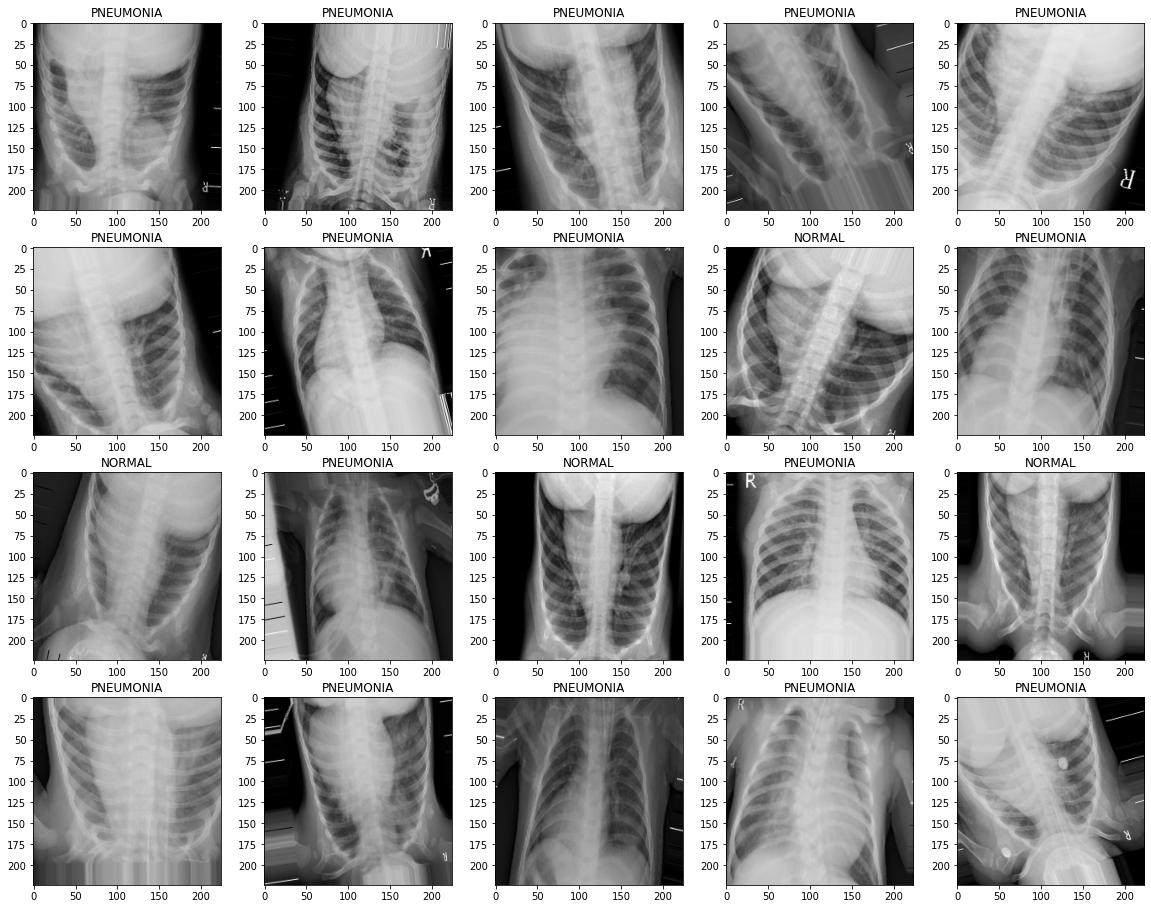

In [ ]:
show_batch(image_batch, label_batch)

### Model Building (layers)


In [ ]:
input_shape = image_batch.shape[1:] #(224, 224, 3)

In [ ]:
dense169_base = DenseNet169(weights='imagenet',
            input_shape = input_shape,
            include_top = False,
          )

In [ ]:
dense121_base = DenseNet121(weights='imagenet',
            input_shape = input_shape,
            include_top = False,
          )

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
# vgg_base.summary()

In [ ]:
# looping to freezing layers before and after compilation
for layer in dense121_base.layers:
  layer.trainable = False

for layer in dense169_base.layers:
  layer.trainable = False

In [ ]:
input_layer = Input(shape = input_shape)

model_dense = dense169_base(input_layer)
model_dense = GlobalAveragePooling2D()(model_dense)
output_dense = Flatten()(model_dense)

# if have a more one models can concatenated them with together.
# merged = tf.keras.layers.Concatenate()([output_mobilenet, output_vgg])

# layers
x = BatchNormalization()(output_dense)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)


stacked_model = Model(inputs=input_layer, outputs=x)

In [ ]:
input_layer = Input(shape = input_shape)

model_121 = dense121_base(input_layer)
model_121= GlobalAveragePooling2D()(model_121)
output_121 = Flatten()(model_121)

# layers
x = BatchNormalization()(output_121)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)


stacked_model = Model(inputs=input_layer, outputs=x)

### Model Compilation

In [ ]:
stacked_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

### Training model

In [ ]:
train_generator.image_shape

(224, 224, 3)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32

In [ ]:
# model_history.history

In [ ]:
model_history = stacked_model.fit(train_generator,
                                  epochs = EPOCHS, 
                                  batch_size = BATCH_SIZE,
                                  validation_data = test_generator,
                                  class_weight = {0:1, 1:1},
                                    )

Epoch 1/15
164/164 [==============================] - 120s 684ms/step - loss: 0.2439 - accuracy: 0.8976 - val_loss: 0.2177 - val_accuracy: 0.9183
Epoch 2/15
164/164 [==============================] - 110s 669ms/step - loss: 0.1634 - accuracy: 0.9362 - val_loss: 0.2035 - val_accuracy: 0.9311
Epoch 3/15
164/164 [==============================] - 108s 658ms/step - loss: 0.1592 - accuracy: 0.9400 - val_loss: 0.1928 - val_accuracy: 0.9263
Epoch 4/15
164/164 [==============================] - 107s 655ms/step - loss: 0.1495 - accuracy: 0.9419 - val_loss: 0.1748 - val_accuracy: 0.9375
Epoch 5/15
164/164 [==============================] - 110s 675ms/step - loss: 0.1465 - accuracy: 0.9448 - val_loss: 0.1666 - val_accuracy: 0.9439
Epoch 6/15
164/164 [==============================] - 109s 662ms/step - loss: 0.1312 - accuracy: 0.9480 - val_loss: 0.1663 - val_accuracy: 0.9423
Epoch 7/15
164/164 [==============================] - 108s 657ms/step - loss: 0.1372 - accuracy: 0.9474 - val_loss: 0.1473 -

### Draw layer of model

In [ ]:
# https://analyticsindiamag.com/how-to-visualize-deep-learning-models-using-visualkeras/
!pip install visualkeras
import visualkeras

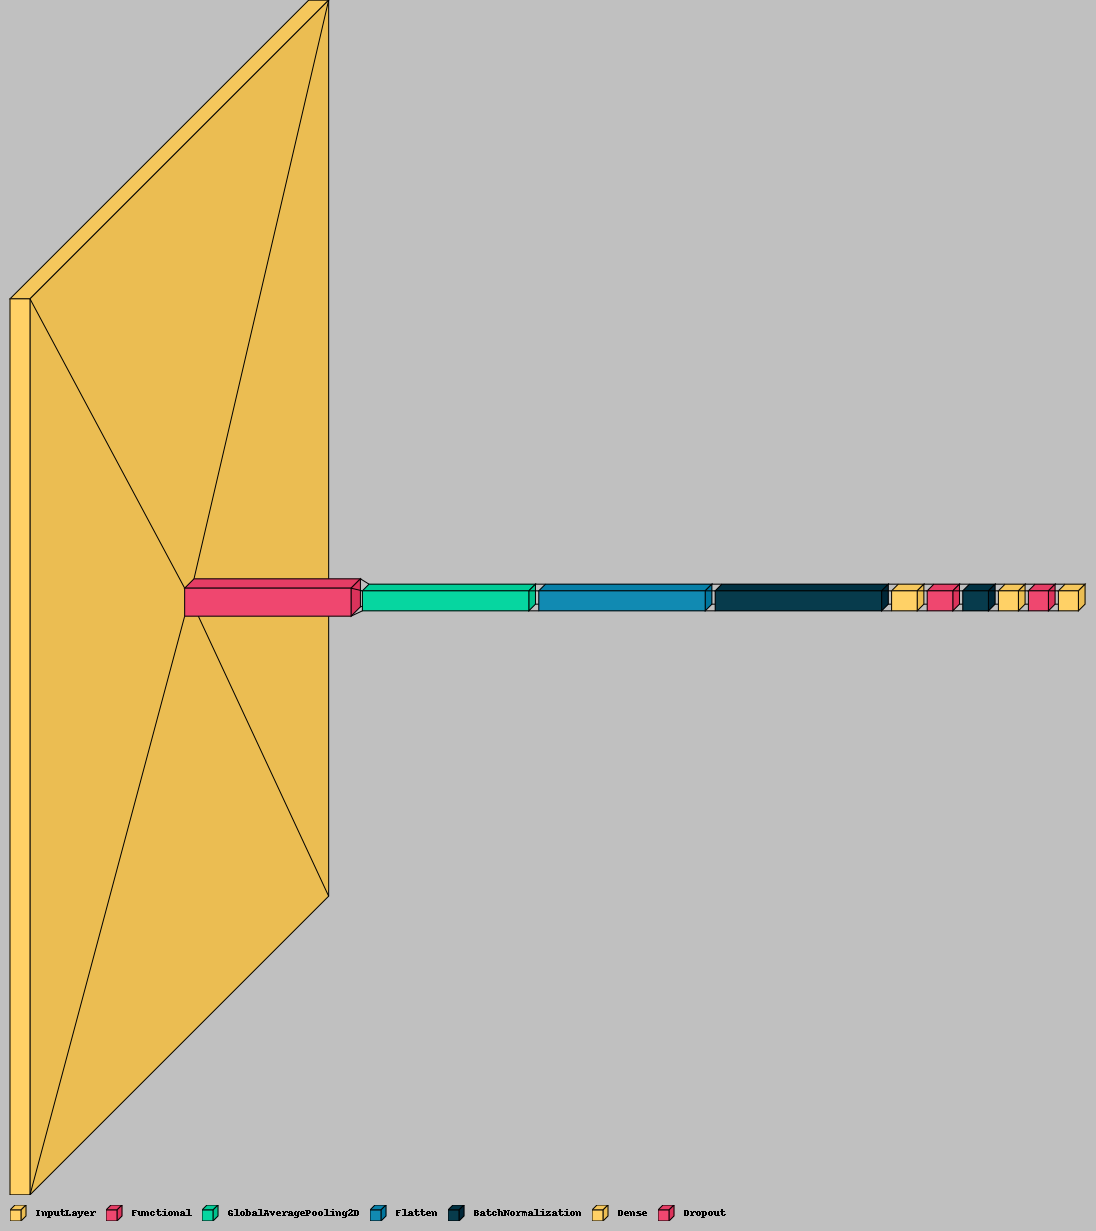

In [ ]:
visualkeras.layered_view(stacked_model, legend=True, background_fill='silver')

### show result by plot_metrics

In [ ]:
def plot_metrics(model_history):
  acc = model_history['accuracy']
  loss = model_history['loss']
  val_acc = model_history['val_accuracy']
  val_loss = model_history['val_loss']

  fig, axs = plt.subplots(1,2, figsize=(13, 7))
  axs[0].plot(acc, label='train_accuracy')
  axs[0].plot(val_acc, label='val_accuracy')
  axs[0].legend(loc='lower right')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')

  axs[1].plot(loss, label='train_loss')
  axs[1].plot(val_loss, label='val_loss')
  axs[1].legend(loc='upper right')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  fig.show()

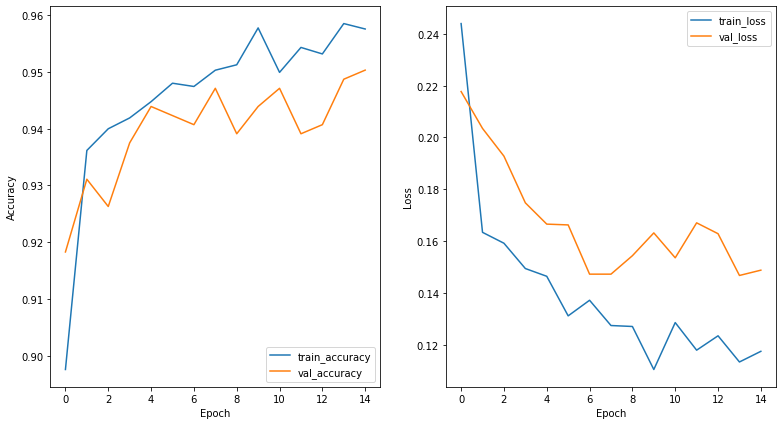

In [ ]:
plot_metrics(model_history.history)

## it saves the model weight

In [ ]:
stacked_model.save_weights("model.h5")